In [1]:
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from batchflow import Pipeline, B, C, D, F, V, W, P, R
from batchflow.models.torch import EncoderDecoder, UNet
from batchflow.models.torch.layers import ConvBlock
from batchflow.models.torch.layers.modules import ASPP
from batchflow.opensets import PascalSegmentation
from batchflow.models.torch.losses import Dice

prediction = torch.rand([1, 22, 32, 32])
target = torch.randint(0, 21, [1, 1, 32, 32])
loss = Dice()
loss(prediction, target)

In [4]:
dataset = PascalSegmentation(bar='n')

In [5]:
downsample_depth = 1
in_channels = 3
num_classes = 22
IMAGE_SHAPE = (160, 160)

model_config = {
    'inputs/images/shape': (3, 160, 160), # can be commented
    'inputs/targets/classes': num_classes,
    'initial_block/inputs': 'images', # can be commented   
    
    'initial_block': {
        'layout': 'cna cna',
        'strides': [2, 1],
        'filters': [32, 64]
    },

    'body/encoder': {
        'num_stages': downsample_depth,
        'order': ['downsampling', 'skip']
    },    
    'body/encoder/downsample': {
        'layout': 'R' + 'wnacna' * 3 + '|',
        'filters': 'same',
        'strides': [[1, 1, 1, 1, 2, 1]] * downsample_depth,
        'kernel_size': [[3, 1] * 3] * downsample_depth,
        'dilation_rate' : 2,
        'branch': {
            'layout': 'cn', 
            'kernel_size': 1,
            'filters': 'same',
            'strides': 2
        },
    },      

    'body/embedding': {
        'base' : ASPP
    },  

    'body/decoder': {
        'num_stages': downsample_depth,
        'order': ['block', 'combine', 'upsampling'] 
    },

    'body/decoder/blocks': {
        'layout': 'ca',
        'kernel_size': 1,
        'filters': 256
    },

    'body/decoder/upsample': {
        'layout': 'b',
        'scale_factor': 2
    },
    'body/decoder/combine': {
        'op': 'concat',
    },    
    
    'head':{
        'layout': 'b cn',
        'scale_factor': 2,
        'filters': num_classes,
    },

    'loss': Dice(),
    'optimizer': 'Adam'
}

In [6]:
num_classes = 22

def process_mask(x):
    """ Background label is 255 and must be transformed to 21
    to make labels sequential. """
#     x = np.squeeze(x)
    np.place(x, x==255, 21)
    return x

train_pipeline = (dataset.train.p
    .init_variable('loss_history', [])
    .init_model('dynamic', EncoderDecoder, 'model', config=model_config)
    .resize(size=IMAGE_SHAPE, src=['images', 'labels'], dst=['images', 'labels'])
    .cutout(origin=P(R('uniform', 1-1e-8, size=2)),
            shape = P(R('randint', 40, size=2)),
            color = (0, 0, 0),
            src=['images', 'labels'], 
            dst=['images', 'labels'],
            p=0.3)
    .rotate(angle=P(R('uniform', -30, 30)),
            src=['images', 'labels'], 
            dst=['images', 'labels'],
            p=0.3)
    .to_array(channels='first', src=['images', 'labels'], dst=['images', 'labels'])
    .process_mask(B('labels'), save_to=B('labels'))
    .train_model('model', B('images'), B('labels'),
                fetches='loss', save_to=V('loss_history', mode='a'), use_lock=True)
)

In [7]:
batch = train_pipeline.next_batch(3)

../batchflow/batchflow/models/torch/losses/multiclass.py:30: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  ../aten/src/ATen/native/TensorIterator.cpp:918.)
  intersection = torch.sum(prediction * target, dims)


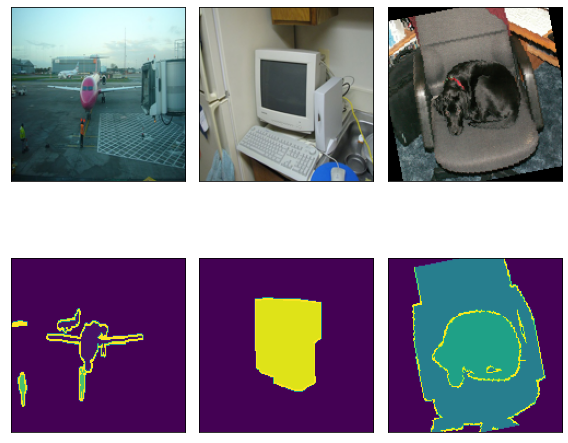

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    if picture_num<3:        
        ax.imshow(np.moveaxis(batch.images[picture_num] / 255, 0, -1))
    elif picture_num < 6:
        ax.imshow(np.squeeze(batch.labels)[picture_num-3])


plt.tight_layout()
plt.show()

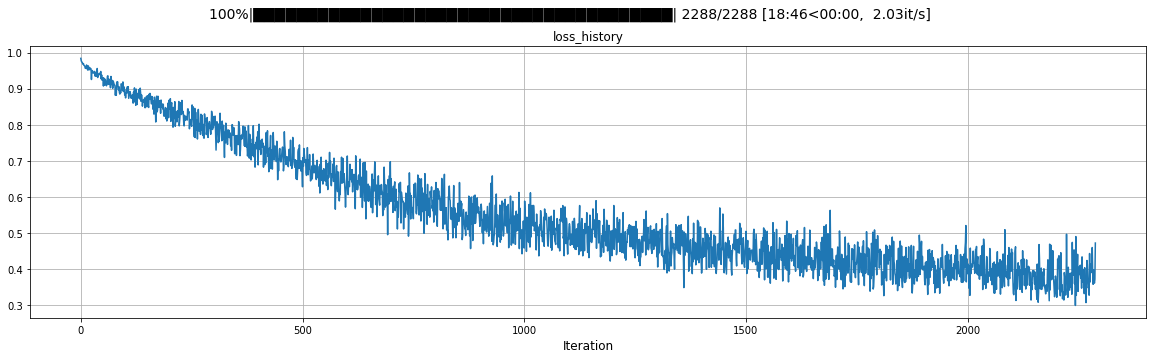

In [10]:
train_pipeline.run(64, n_epochs=100, shuffle=True,
                   bar={'bar': 'n', 'frequency': 10,
                        'graphs': 'loss_history'})

# test

In [ ]:
pipeline = (dataset.test.p
                .import_model('model', train_pipeline)
                .init_variable('metrics')
                .init_variable('predictions')           
                .resize(size=IMAGE_SHAPE, src=['images', 'labels'], dst=['images', 'labels'])
                .to_array(channels='first', src=['images', 'labels'], dst=['images', 'labels'])
                .process_mask(B('labels'), save_to=B('labels'))                
                .predict_model('model', B('images'), fetches='predictions',
                               save_to=V('predictions'))
                .gather_metrics('classification', B('labels'), V('predictions'),
                                 axis=1, fmt='logits', num_classes=num_classes,
                                 save_to=V('metrics', mode='update'))
            )

In [ ]:
pipeline.run(32, drop_last=False, bar='n')

In [ ]:
f1_scores = pipeline.v('metrics').evaluate('f1_score', agg='mean', multiclass=None)

In [ ]:
f1_scores 

In [ ]:
f1_scores = pipeline.v('metrics').evaluate('f1_score', agg='mean', multiclass=None)

In [ ]:
batch = pipeline.next_batch(3)
outputs = pipeline.v('predictions')[:3]

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    if picture_num<3:        
        ax.imshow(np.moveaxis(batch.images[picture_num] / 255, 0, -1))
    elif picture_num < 6:
        ax.imshow(np.squeeze(batch.labels)[picture_num-3])
    else:
        ax.imshow(np.argmax(outputs[picture_num-6], axis=0))


plt.tight_layout()
plt.show()

# train inference

In [ ]:
train_metrics_pipeline = (dataset.train.p
                          .import_model('model', train_pipeline)
                          .init_variable('metrics')
                          .init_variable('predictions')   
                          .resize(size=IMAGE_SHAPE, src=['images', 'labels'], dst=['images', 'labels'])
                          .to_array(channels='first', src=['images', 'labels'], dst=['images', 'labels'])
                          .process_mask(B('labels'), save_to=B('labels'))          
                          .predict_model('model', B('images'), fetches='predictions',
                                         save_to=V('predictions'))
                          .gather_metrics('classification', B('labels'), V('predictions'),
                                          axis=1, fmt='logits', num_classes=num_classes,
                                          save_to=V('metrics', mode='update'))
)

In [ ]:
train_metrics_pipeline.run(32, drop_last=False, bar='n')

In [ ]:
f1_scores_train = train_metrics_pipeline.v('metrics').evaluate('f1_score', agg='mean', multiclass=None)

In [ ]:
batch = train_metrics_pipeline.next_batch(3)
outputs = train_metrics_pipeline.v('predictions')[:3]

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    if picture_num<3:        
        ax.imshow(np.moveaxis(batch.images[picture_num] / 255, 0, -1))
    elif picture_num < 6:
        ax.imshow(np.squeeze(batch.labels)[picture_num-3])
    else:
        ax.imshow(np.argmax(outputs[picture_num-6], axis=0))


plt.tight_layout()
plt.show()

# comparison

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = [f1_scores_train, f1_scores]

X = np.arange(len(f1_scores))
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25, label='train metrics')
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25, label='test metrics')
plt.title("f1_score per class")
plt.xticks(X, X+1)
plt.legend()
plt.show()

In [ ]:
print(f"Train: {np.mean(f1_scores_train)}, test: {np.mean(f1_scores)}")